In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

folder = 'Lab_AEK/'
test_names = [str(i+1) for i in range(7)]
dfs = []
for test_name in test_names:
    dfs.append(pd.read_csv(test_name+'.csv'))

In [4]:
def average(arr):
    avr = 0
    for i in arr:
        avr += i
    avr = avr/len(arr)
    return avr

def random_grex(arr, avr):
    disp = 0
    for i in arr:
        disp += (i - avr)**2
    n = len(arr)
    grex = (1/(n*(n-1))*disp)**0.5
    return grex

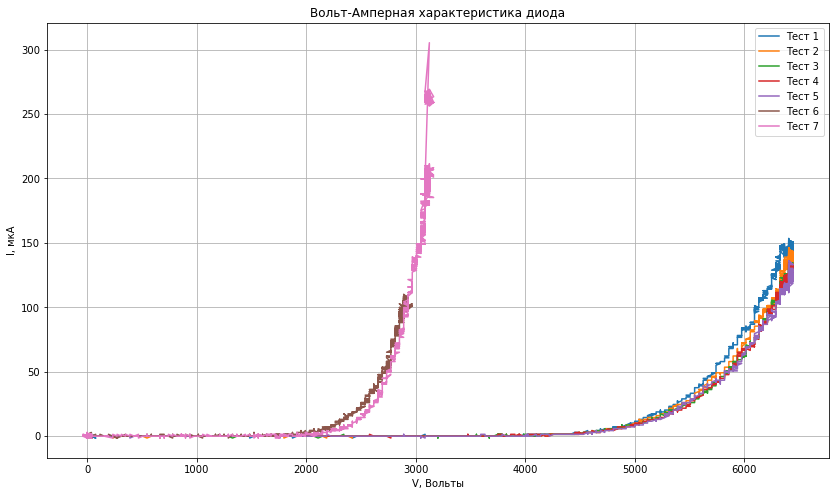

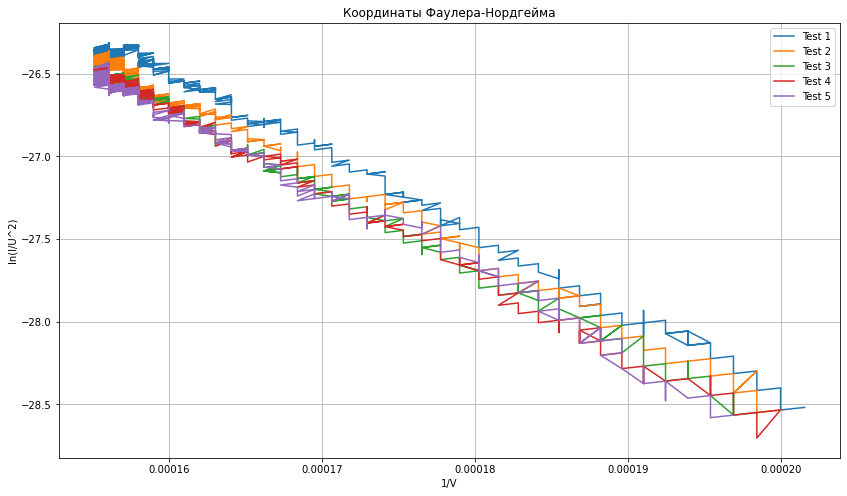

Форм-фактор: (9.2e-05 +- 1.2e-06) с максимальным отлонением в 3.3532039470933004 сигма


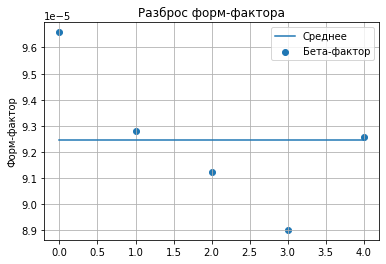

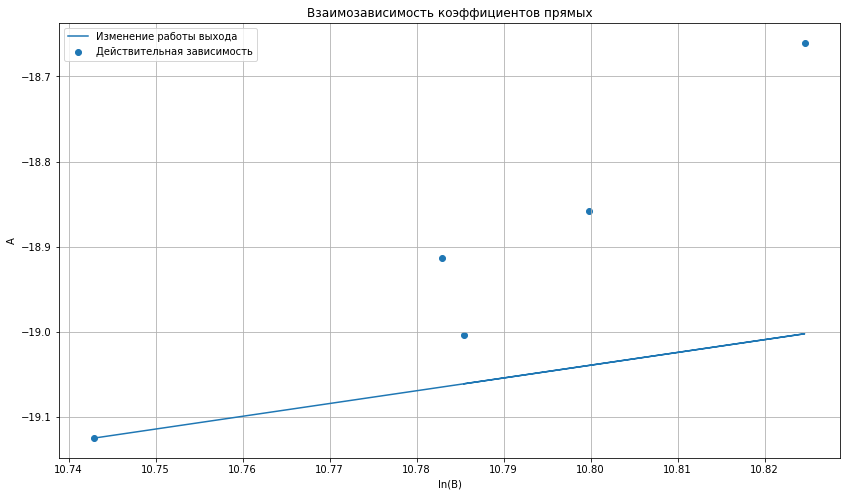

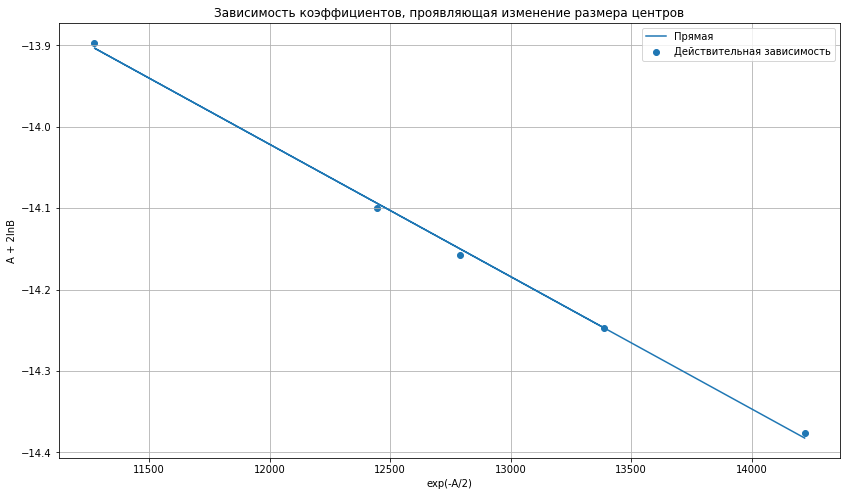

In [5]:
v1_column = 4
v2_column = 10
scale_row = 7
scale_v1_column = 1
scale_v2_column = 7

phi = 3.5 #эВ

beta_vals = []

def beta_func(a, phi):
    beta = -0.683*phi**1.5/a
    return beta

Resistor_value = 27_000 #Ohm

#ln(I/U^2) = A - B*1/U

graphs = []

def x_spec_coord(U):
    return 1/U

def y_spec_coord(I, U):
    argument = I/U**2
    result = np.array([math.log(val) for val in argument])
    return result


for df in dfs:
    raw_array = np.array(df.T)
    
    scale_v1 = float(raw_array.T[scale_row, scale_v1_column])
    scale_v2 = float(raw_array.T[scale_row, scale_v2_column])
    
    v1 = raw_array[v1_column]/scale_v1*1000 #V on the generetor, had a 1000x divider
    v2 = raw_array[v2_column]/scale_v2/Resistor_value #I through the diod, measured across a resistor
    
    graphs.append([v1, v2])

for ind, graph in enumerate(graphs):
    plt.plot(graph[0], graph[1]*1e6, label='Тест '+str(ind+1))
    
plt.xlabel('V, Вольты')
plt.ylabel('I, мкА')
plt.grid()
plt.title('Вольт-Амперная характеристика диода')
plt.legend()
plt.gcf().set_size_inches(14, 8)
plt.show()
    
fit_coefs_all = []
    
for ind, graph in enumerate(graphs[:5]):
    U = graph[0]
    I = graph[1]
    #Finding the non-zero part of graph
    prev = I[0]
    start = 0
    threshold = 1e-5
    for i, val in enumerate(I):
        if prev > threshold and val > threshold:
            start = i-1
            break
        else:
            prev = val
    
    U = U[start:]
    I = I[start:]
    
    x = x_spec_coord(U)
    y = y_spec_coord(I, U)
    
    plt.plot(x, y, label='Test ' + str(ind+1))
    
    a, b = np.polyfit(list(x), list(y), 1)
    fit_coefs_all.append([a,b])
    
plt.xlabel('1/V')
plt.ylabel('ln(I/U^2)')
plt.legend()
plt.grid()
plt.title('Координаты Фаулера-Нордгейма')
plt.gcf().set_size_inches(14, 8)
plt.show()

#calculating the beta-factor
beta_vals = [beta_func(coef[0], phi) for coef in fit_coefs_all]

avr_beta = average(beta_vals)
beta_grex = random_grex(beta_vals, avr_beta)

#Calculting the maximum divergance in sigma
cur_max = 0
for beta in beta_vals:
    divergance = abs(beta - avr_beta)/beta_grex
    if divergance > cur_max:
        cur_max = divergance

print(f"Форм-фактор: ({avr_beta:.1e} +- {beta_grex:.1e}) с максимальным отлонением в {cur_max} сигма")

#Showing the form-factor distribution
plt.scatter(range(len(beta_vals)), beta_vals, label='Бета-фактор')
plt.plot(range(len(beta_vals)), [avr_beta for i in range(len(beta_vals))], label='Среднее')
plt.grid()
plt.legend()
plt.ylabel('Форм-фактор')
plt.title('Разброс форм-фактора')
plt.show()

#Showing the coefs gradient
x_lnB = [math.log(-val[0]) for val in fit_coefs_all[:5]]
y_A = [val[1] for val in fit_coefs_all[:5]]

#Building a 1.5 coef line
b_0 = y_A[0] - 1.5*x_lnB[0]
y_est = [1.5*val + b_0 for val in x_lnB]

plt.scatter(x_lnB, y_A, label='Действительная зависимость')
plt.plot(x_lnB, y_est, label='Изменение работы выхода')
plt.title('Взаимозависимость коэффициентов прямых')
plt.grid()
plt.legend()
plt.xlabel('ln(B)')
plt.gcf().set_size_inches(14, 8)
plt.ylabel('A')
plt.show()

#Showing the size-relevant coefs graph

x_size = [math.exp(-val/2) for val in y_A]
y_size = [y_A[k] + 2*math.log(x_lnB[k]) for k in range(len(y_A))]

a_size, b_size = np.polyfit(x_size, y_size, 1)
y_est_size = [val*a_size + b_size for val in x_size]

plt.plot(x_size, y_est_size, label='Прямая')
plt.scatter(x_size, y_size, label='Действительная зависимость')
plt.title('Зависимость коэффициентов, проявляющая изменение размера центров')
plt.legend()
plt.grid()
plt.xlabel('exp(-A/2)')
plt.ylabel('A + 2lnB')
plt.gcf().set_size_inches(14, 8)
plt.show()